In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 4.9 MB/s 
     |████████████████████████████████| 101 kB 13.7 MB/s 
     |████████████████████████████████| 596 kB 65.5 MB/s 
     |████████████████████████████████| 6.6 MB 44.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
import numpy as np
import regex as re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import math
import os

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.backend as K
import transformers
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification

from collections import Counter

import warnings
warnings.filterwarnings("ignore")

In [4]:
# Import the training and test .csv files
colnames=['image_path', 'text', 'food']
train = pd.read_csv(r'/content/drive/MyDrive/Fusion/Dataset/train_titles.csv', names=colnames, header=None, sep = ',', index_col=['image_path'])
test = pd.read_csv(r'/content/drive/MyDrive/Fusion/Dataset/test_titles.csv', names=colnames, header=None, sep = ',', index_col=['image_path'])

In [5]:
# Sort values by 'image_path'
test = test.sort_values('image_path')
train = train.sort_values('image_path')

In [6]:
train.head()

,text,food
image_path,,
apple_pie_0.jpg,Apple pie - Wikipedia,apple_pie
apple_pie_100.jpg,Glazed Apple Pie Squares Recipe | Taste of Home,apple_pie
apple_pie_101.jpg,Mock Apple Pie Recipe - Allrecipes.com,apple_pie
apple_pie_102.jpg,Crock-Pot Ladies Crock-Pot Apple Pie Moonshine,apple_pie
apple_pie_104.jpg,All-Star Apple Pie Recipe | Taste of Home,apple_pie


In [7]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    sentence = sentence.lower()

    return sentence

def remove_tags(text):
    return TAG_RE.sub('', text)

TAG_RE = re.compile(r'<[^>]+>')
vec_preprocess_text = np.vectorize(preprocess_text)

In [8]:
from tensorflow.keras import utils
from sklearn.preprocessing import LabelEncoder

In [9]:
nClasses = train.food.nunique()

In [10]:
nClasses

6

In [11]:

encoder = LabelEncoder()
processed_train = vec_preprocess_text(train.text.values)
processed_test = vec_preprocess_text(test.text.values)


encoded_labels_train = encoder.fit_transform(train.food.values)
labels_train = utils.to_categorical(encoded_labels_train, nClasses)

encoded_labels_test = encoder.fit_transform(test.food.values)
labels_test = utils.to_categorical(encoded_labels_test, nClasses)

print("Processed text sample:", processed_train[0])
print("Shape of train labels:", labels_train.shape)

Processed text sample: apple pie wikipedia
Shape of train labels: (4117, 6)


In [12]:
train

,text,food
image_path,,
apple_pie_0.jpg,Apple pie - Wikipedia,apple_pie
apple_pie_100.jpg,Glazed Apple Pie Squares Recipe | Taste of Home,apple_pie
apple_pie_101.jpg,Mock Apple Pie Recipe - Allrecipes.com,apple_pie
apple_pie_102.jpg,Crock-Pot Ladies Crock-Pot Apple Pie Moonshine,apple_pie
apple_pie_104.jpg,All-Star Apple Pie Recipe | Taste of Home,apple_pie
...,...,...
grilled_cheese_sandwich_970.jpg,Fresh Avocado Grilled Cheese Sandwich | Food R...,grilled_cheese_sandwich
grilled_cheese_sandwich_971.jpg,Grilled Cheese Sandwich Recipes on Pinterest,grilled_cheese_sandwich
grilled_cheese_sandwich_972.jpg,"[[""It's National Grilled Cheese Sandwich Month...",grilled_cheese_sandwich


In [13]:
train.food=train.food.replace({'apple_pie':0, 'carrot_cake':1, 'cheesecake':2, 'club_sandwich':3, 'falafel':4, 'grilled_cheese_sandwich':5})

In [14]:
train.food = train.food.astype(float)

In [15]:
test.food=test.food.replace({'apple_pie':0, 'carrot_cake':1, 'cheesecake':2, 'club_sandwich':3, 'falafel':4, 'grilled_cheese_sandwich':5})
test.food = test.food.astype(float)

In [16]:
processed_train

array(['apple pie wikipedia',
       'glazed apple pie squares recipe taste of home',
       'mock apple pie recipe allrecipes com', ...,
       ' it national grilled cheese sandwich month recipes more follow me foodie ',
       'best grilled cheese sandwich recipe',
       'hot eats and cool reads grilled cheese sandwich with bacon'],
      dtype='<U213')

In [17]:
MODEL_NAME = 'roberta-base'
MAX_LEN = 50

BATCH_SIZE = 64
EPOCHS = 3

In [18]:
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [19]:
# Preprocessing of texts according to roberta

def get_masks(text, max_length):
    """Mask for padding"""
    tokens = tokenizer.tokenize(text)
    tokens = ["[CLS]"] + tokens + ["[SEP]"]
    length = len(tokens)
    if length > max_length:
        tokens = tokens[:max_length]

    return np.asarray([1]*len(tokens) + [0] * (max_length - len(tokens)))

vec_get_masks = np.vectorize(get_masks, signature = '(),()->(n)')

def get_segments(text, max_length):
    """Segments: 0 for the first sequence, 1 for the second"""
    tokens = tokenizer.tokenize(text)
    tokens = ["[CLS]"] + tokens + ["[SEP]"]
    length = len(tokens)
    if length > max_length:
        tokens = tokens[:max_length]
    
    segments = []
    current_segment_id = 0
    with_tags = ["[CLS]"] + tokens + ["[SEP]"]
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return np.asarray(segments + [0] * (max_length - len(tokens)))

vec_get_segments = np.vectorize(get_segments, signature = '(),()->(n)')

def get_ids(text, tokenizer, max_length):
    """Token ids from Tokenizer vocab"""
    tokens = tokenizer.tokenize(text)
    tokens = ["[CLS]"] + tokens + ["[SEP]"]
    length = len(tokens)
    if length > max_length:
        tokens = tokens[:max_length]

    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_ids = np.asarray(token_ids + [0] * (max_length-length))
    return input_ids

vec_get_ids = np.vectorize(get_ids, signature = '(),(),()->(n)')


def prepare(text_array, tokenizer, max_length = 50):
    
    ids = vec_get_ids(text_array, 
                      tokenizer, 
                      max_length).squeeze()
    masks = vec_get_masks(text_array,
                      max_length).squeeze()
    segments = vec_get_segments(text_array,
                      max_length).squeeze()

    return ids, segments, masks

In [20]:
ids_train, segments_train, masks_train = prepare(processed_train,
                                                 tokenizer,
                                                 50)
ids_test, segments_test, masks_test = prepare(processed_test, 
                                               tokenizer,
                                               50)

In [21]:
ids_train

array([[    3, 27326, 11637, ...,     0,     0,     0],
       [    3,  7210, 16314, ...,     0,     0,     0],
       [    3,   119,  3343, ...,     0,     0,     0],
       ...,
       [    3,    24,   632, ...,     0,     0,     0],
       [    3,  7885, 20346, ...,     0,     0,     0],
       [    3, 10120, 24923, ...,     0,     0,     0]])

In [22]:
input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')
segment_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32,
                                    name="segment_ids")
roberta_model = TFRobertaForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=6)
x = roberta_model([input_word_ids,input_mask,segment_ids])
x = x[0]
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
output = tf.keras.layers.Dense(6, activation='softmax')(x)
model = tf.keras.Model(inputs=[input_word_ids,input_mask,segment_ids], outputs=[output])

Downloading:   0%|          | 0.00/627M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
model.compile(
            optimizer=tf.keras.optimizers.Adam(lr=1e-5),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 50)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 50)]         0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 50)]         0           []                               
                                                                                                  
 tf_roberta_for_sequence_classi  TFSequenceClassifie  124650246  ['input_word_ids[0][0]',         
 fication (TFRobertaForSequence  rOutput(loss=None,               'input_mask[0][0]',         

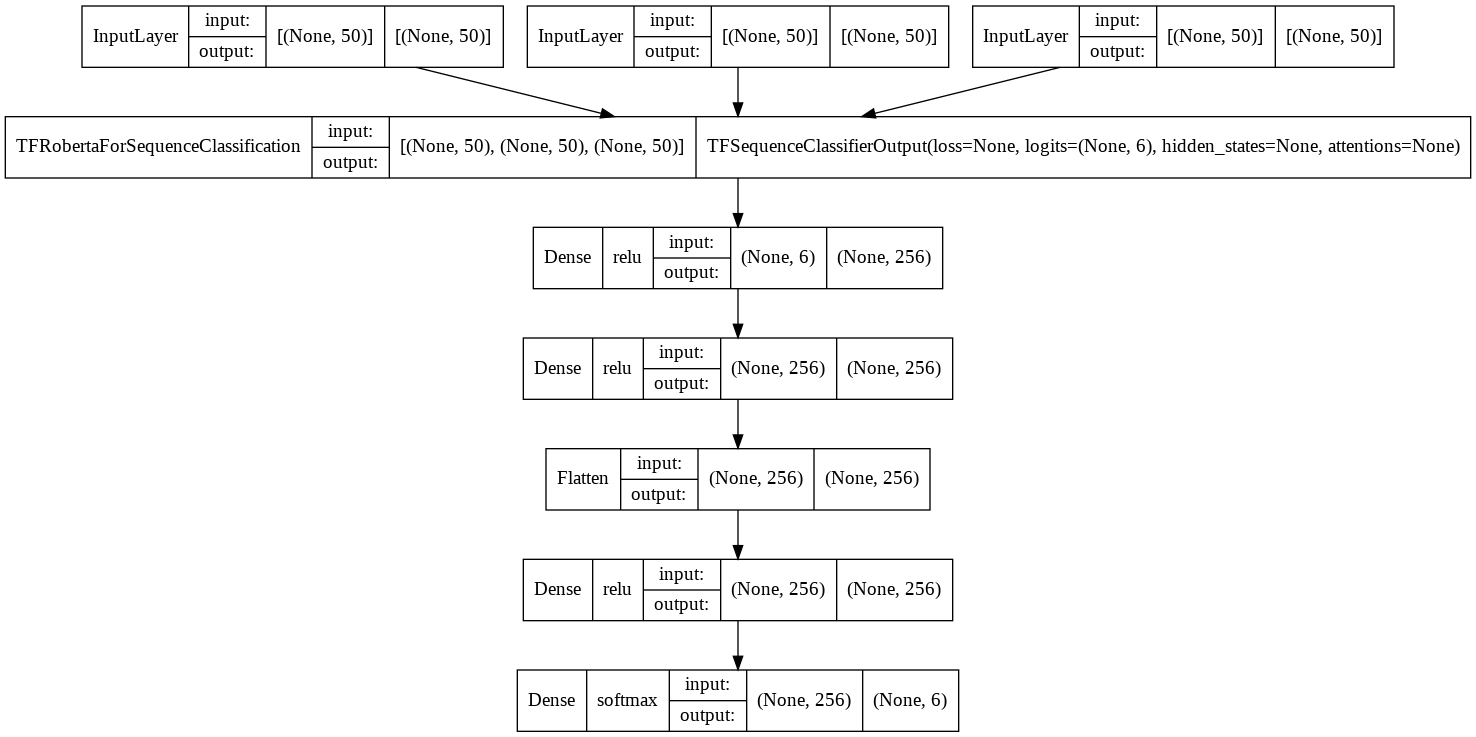

In [24]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=False,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
)

In [25]:
history = model.fit([ids_train, masks_train, segments_train], 
          train.food,
          epochs = 10,
          batch_size = 64,
          validation_data= ([ids_test, masks_test,segments_test], test.food)
          )

Epoch 1/10
65/65 [==============================] - 61s 693ms/step - loss: 1.7795 - accuracy: 0.2526 - val_loss: 1.6731 - val_accuracy: 0.5193
Epoch 2/10
65/65 [==============================] - 43s 670ms/step - loss: 1.4651 - accuracy: 0.7620 - val_loss: 1.1456 - val_accuracy: 0.9098
Epoch 3/10
65/65 [==============================] - 45s 692ms/step - loss: 0.9788 - accuracy: 0.9072 - val_loss: 0.7312 - val_accuracy: 0.9222
Epoch 4/10
65/65 [==============================] - 44s 683ms/step - loss: 0.6223 - accuracy: 0.9293 - val_loss: 0.4909 - val_accuracy: 0.9258
Epoch 5/10
65/65 [==============================] - 45s 686ms/step - loss: 0.3939 - accuracy: 0.9446 - val_loss: 0.3752 - val_accuracy: 0.9258
Epoch 6/10
65/65 [==============================] - 44s 685ms/step - loss: 0.2801 - accuracy: 0.9509 - val_loss: 0.3280 - val_accuracy: 0.9244
Epoch 7/10
65/65 [==============================] - 44s 684ms/step - loss: 0.2099 - accuracy: 0.9580 - val_loss: 0.3351 - val_accuracy: 0.9215